# ESA TRAINING COURSE, SNOW COVER EXTENT

During this exercise we will use Optical Multispectral data for mapping snow cover.

In that specific case we will use a **Sentinel-2** scene.

## Data Visualization on Qgis

1. Open QGIS
2. ktm

## Getting Started

First, let's load the necessary libraries:

In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from osgeo import gdal
import glob
import rasterio
import os
import numpy as np
import geopandas as gpd
from rasterio.sample import sample_gen
import pandas as pd

***

## Read image

The bands are stored in the folder **S2B_MSIL1C_20201125T103349_N0209_R108_T32TLR_20201125T114106_10m**

## Explore bands

Now you have 10 minutes to get familiar with the Sentinel-2 bands.
Try to read and look inside each band.

- What do you notice? What is the snow and other classes behaviour?
- Which bands do you think are giving the most information about snow cover?

Use the table and the image for orientating through the bands.

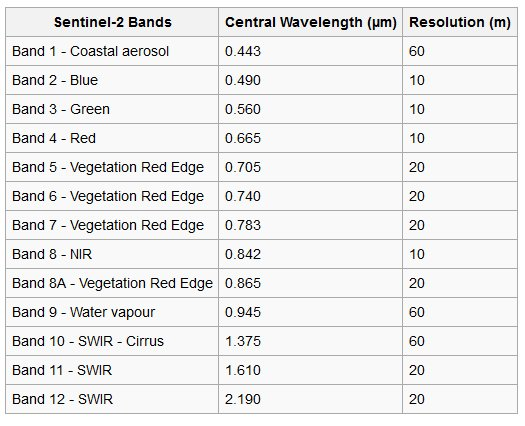

./S2B_MSIL1C_20201125T103349_N0209_R108_T32TLR_20201125T114106_10m/T32TLR_20201125T103349_B08_toa.tif


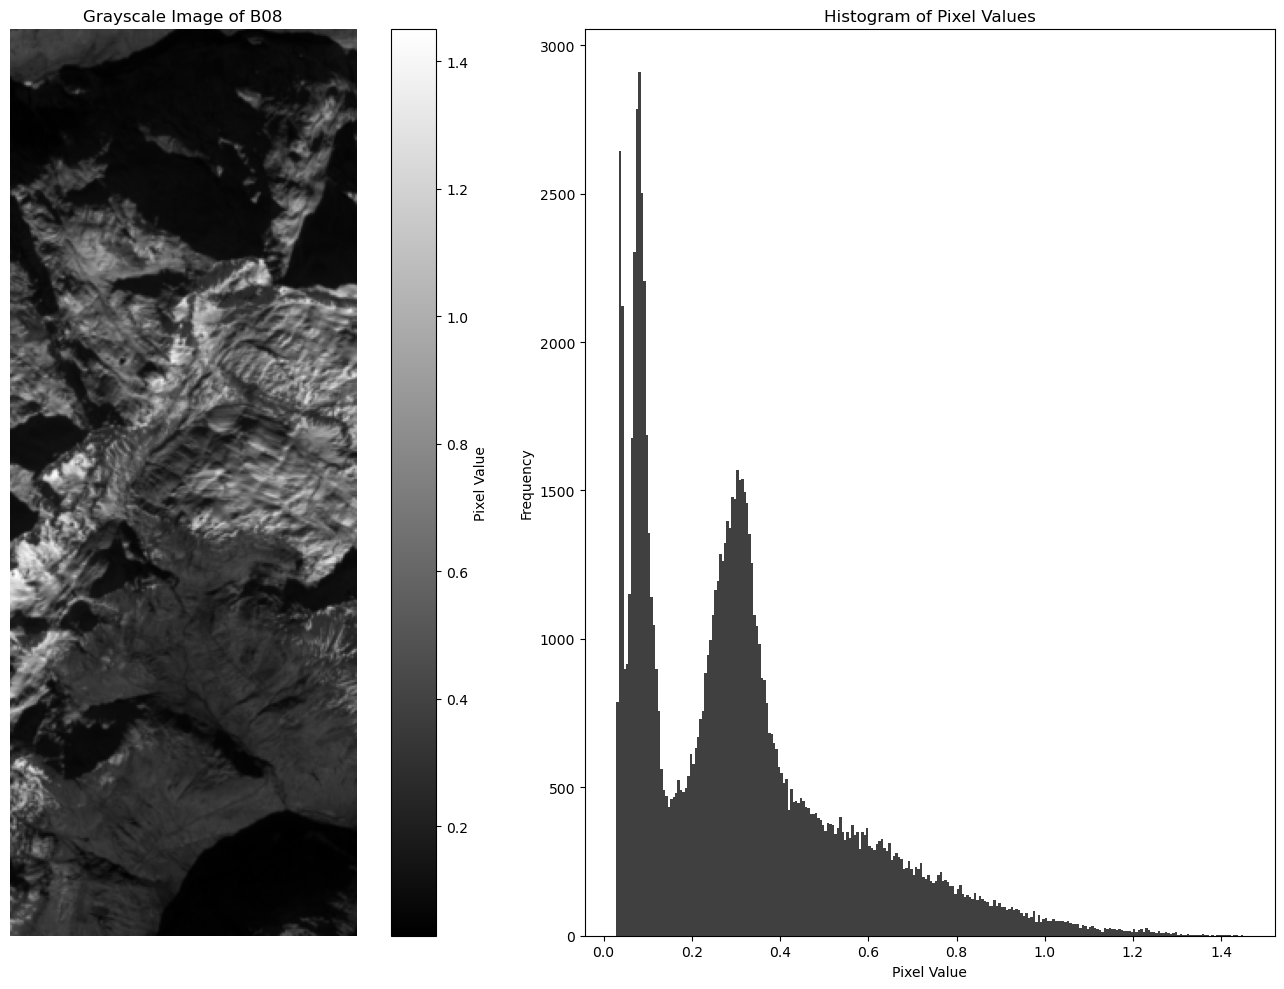

In [138]:
# Define the specific band name you're interested in analyzing
current_band_name = 'B08'

# Get the current working directory to establish the starting point for the search
current_dir = os.getcwd()

# Use glob to search for the specific TIFF file that matches the band name (B11) within subdirectories
# './S2*' matches directories starting with 'S2' (e.g., Sentinel-2 data folders)
# '*' + current_band_name + '*.tif' matches any TIFF file that contains the band name in its filename
current_band_path = glob.glob(os.path.join('./S2*', '*' + current_band_name + '*.tif'))[0]

# Print the full path to the identified file for confirmation
print(current_band_path)

# Open the identified image file using rasterio, which handles geospatial raster data
with rasterio.open(current_band_path) as dataset:
    # Read the first (and typically only) band of the image as a 2D array
    band = dataset.read(1)
    
    # Create a figure with two subplots arranged in one row and two columns
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))  # Adjust figure size as needed
    
    # Plot the image data in grayscale on the first subplot
    img_plot = ax[0].imshow(band, cmap='gray')  # cmap='gray' ensures the image is displayed in grayscale
    ax[0].set_title(f'Grayscale Image of {current_band_name}')  # Set a title indicating which band is shown
    ax[0].axis('off')  # Remove the axis labels for a cleaner image display
    
    # Add a colorbar to the grayscale image for reference, indicating the range of pixel values
    cbar = plt.colorbar(img_plot, ax=ax[0], orientation='vertical')
    cbar.set_label('Pixel Value')  # Label the colorbar to explain what the values represent

    # Plot the histogram of pixel values on the second subplot
    # .ravel() flattens the 2D array into a 1D array of pixel values for histogram creation
    ax[1].hist(band.ravel(), bins=256, color='black', alpha=0.75)
    ax[1].set_title('Histogram of Pixel Values')  # Title for the histogram plot
    ax[1].set_xlabel('Pixel Value')  # X-axis label indicating pixel intensity levels
    ax[1].set_ylabel('Frequency')  # Y-axis label indicating how often each pixel value occurs

    # Use tight_layout() to adjust subplots to fit into the figure area neatly
    plt.tight_layout()
    
    # Display the entire figure with both plots (image and histogram)
    plt.show()



*** 
## False colour composites for data visualization

RGB composites help us to visually better interprete the scene. 

Use the consideratins you did before to combine different bands for creating a good combination for visualization.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


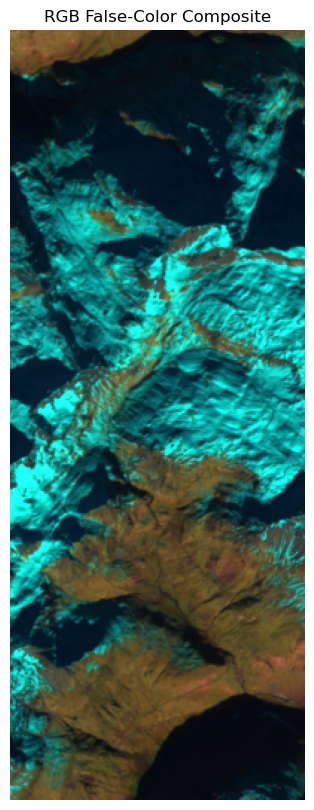

In [139]:
# Define the band names for RGB (false color), Green, and SWIR bands
red_channel_band_name = 'B11'
green_channel_band_name = 'B08'
blue_channel_band_name = 'B03'

# Get the current working directory
current_dir = os.getcwd()

# Use glob to find the paths for the necessary bands
red_channel_band_path = glob.glob(os.path.join('./S2*', '*' + red_channel_band_name + '*.tif'))[0]
green_channel_band_path = glob.glob(os.path.join('./S2*', '*' + green_channel_band_name + '*.tif'))[0]
blue_channel_band_path = glob.glob(os.path.join('./S2*', '*' + blue_channel_band_name + '*.tif'))[0]



# Open and read the RGB and SWIR bands
with rasterio.open(red_channel_band_path) as red_dataset, \
     rasterio.open(green_channel_band_path) as green_dataset, \
     rasterio.open(blue_channel_band_path) as blue_dataset:
    
    # Read the bands as 2D arrays
    red_band = red_dataset.read(1)
    green_band = green_dataset.read(1)
    blue_band = blue_dataset.read(1)

    rgb_false_color = np.dstack((red_band, green_band, blue_band))

    # Plot the RGB false-color image, snow map, and NDSI histogram with the threshold
    plt.figure(figsize=(20, 10))
    
    # Plot the RGB false-color composite
    plt.imshow(rgb_false_color)  # Normalizing by 10000 for better visualization
    plt.title('RGB False-Color Composite')
    plt.axis('off')
   

***

### NDSI (Normalized Difference Snow Index)

The NDSI is a widely used index for detecting snow cover, and it is calculated using the following formula:

$$
\text{NDSI} = \frac{\text{Green} - \text{SWIR}}{\text{Green} + \text{SWIR}}
$$

Where:
- **Green**: Reflectance in the green band.
- **SWIR**: Reflectance in the short-wave infrared (SWIR) band.

## NDSI computation

Given that NDSI definition now use the next script for reading the green and SWIR bands and compute NDSI.

## Analysis of the results

- Try now in the next 10 minutes to critically discuss what you see.
- What may be the main issues of using NDSI for snow detection?

Green Band Path: ./S2B_MSIL1C_20201125T103349_N0209_R108_T32TLR_20201125T114106_10m/T32TLR_20201125T103349_B03_toa.tif
SWIR Band Path: ./S2B_MSIL1C_20201125T103349_N0209_R108_T32TLR_20201125T114106_10m/T32TLR_20201125T103349_B11_toa.tif


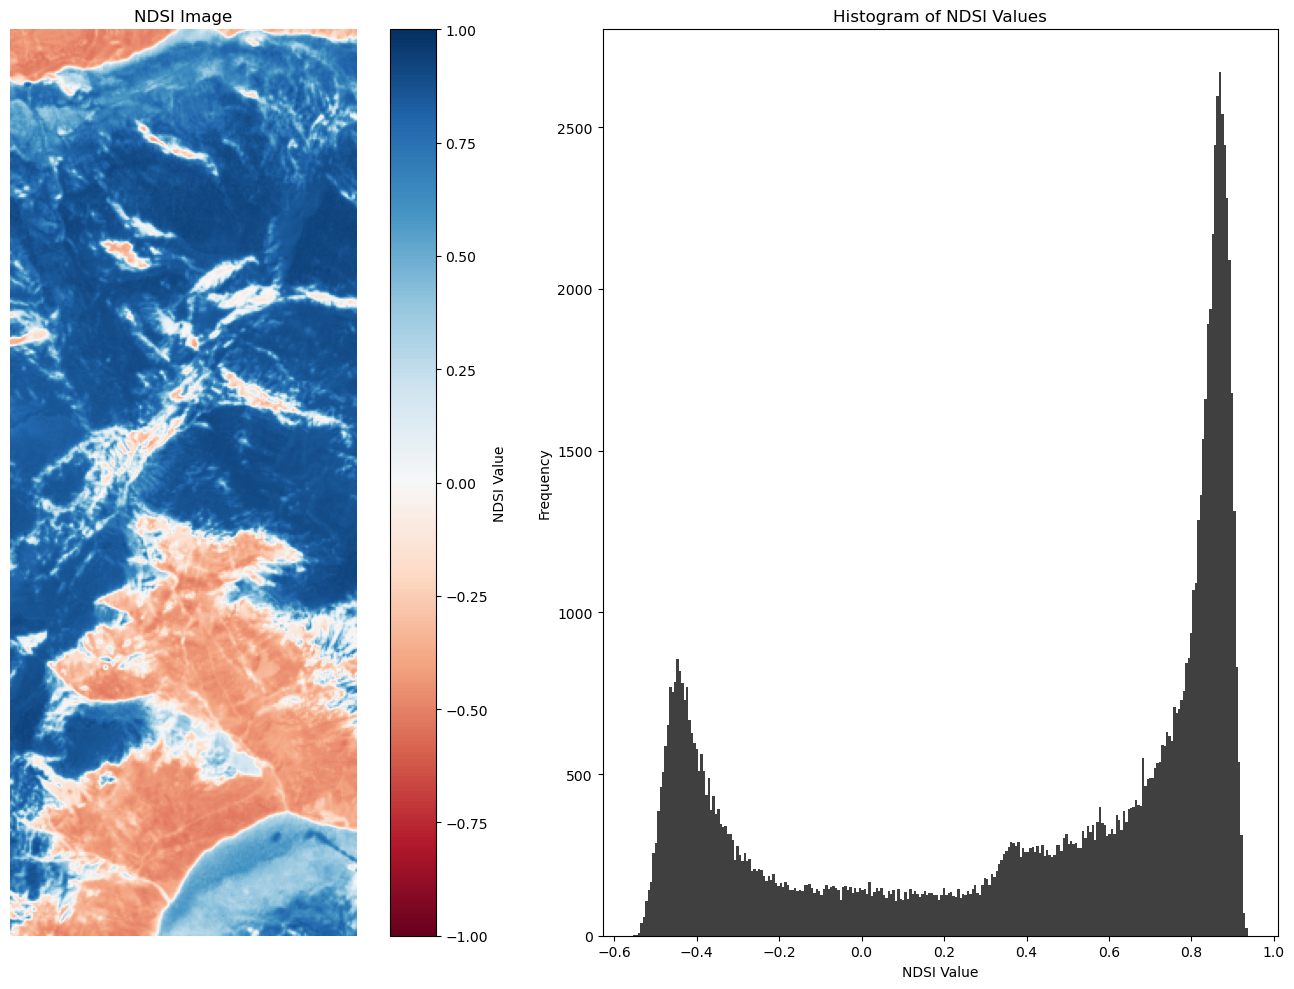

In [140]:
# Define the band names for green and SWIR bands
green_band_name = 'B03'
swir_band_name = 'B11'

# Get the current working directory
current_dir = os.getcwd()

# Use glob to find the paths for the green and SWIR band files
green_band_path = glob.glob(os.path.join('./S2*', '*' + green_band_name + '*.tif'))[0]
swir_band_path = glob.glob(os.path.join('./S2*', '*' + swir_band_name + '*.tif'))[0]

print(f"Green Band Path: {green_band_path}")
print(f"SWIR Band Path: {swir_band_path}")

# Open and read the green and SWIR bands
with rasterio.open(green_band_path) as green_dataset, rasterio.open(swir_band_path) as swir_dataset:
    # Read the first band from each image
    green_band = green_dataset.read(1)
    swir_band = swir_dataset.read(1)

    # Calculate the NDSI using the formula: (Green - SWIR) / (Green + SWIR)
    ndsi = (green_band.astype(float) - swir_band.astype(float)) / (green_band + swir_band)

    # Handle division by zero or other invalid values (like NaN or Inf)
    ndsi = np.where(np.isfinite(ndsi), ndsi, np.nan)

    # Create a figure with two subplots: one for the NDSI image and one for the histogram
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))
    
    # Plot the NDSI image with a colorbar
    img_plot = ax[0].imshow(ndsi, cmap='RdBu', vmin=-1, vmax=1)  # RdBu colormap is useful for NDSI (snow vs no-snow)
    ax[0].set_title('NDSI Image')
    ax[0].axis('off')
    
    # Add a colorbar to the NDSI image
    cbar = plt.colorbar(img_plot, ax=ax[0], orientation='vertical')
    cbar.set_label('NDSI Value')

    # Plot the histogram of NDSI values
    ax[1].hist(ndsi.ravel(), bins=256, color='black', alpha=0.75)
    ax[1].set_title('Histogram of NDSI Values')
    ax[1].set_xlabel('NDSI Value')
    ax[1].set_ylabel('Frequency')

    # Display the plots
    plt.tight_layout()
    plt.show()


***

## Snow mapping applying a threshold on NDSI

Now considering the NDSI map and the relative histogram please select a proper threshold for distinguishing between snow covered and snow free areas.

- Play a bit with the threshold and observe the result
- Critically analyze what can be the main issues using NDSI thresold for snow mapping

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


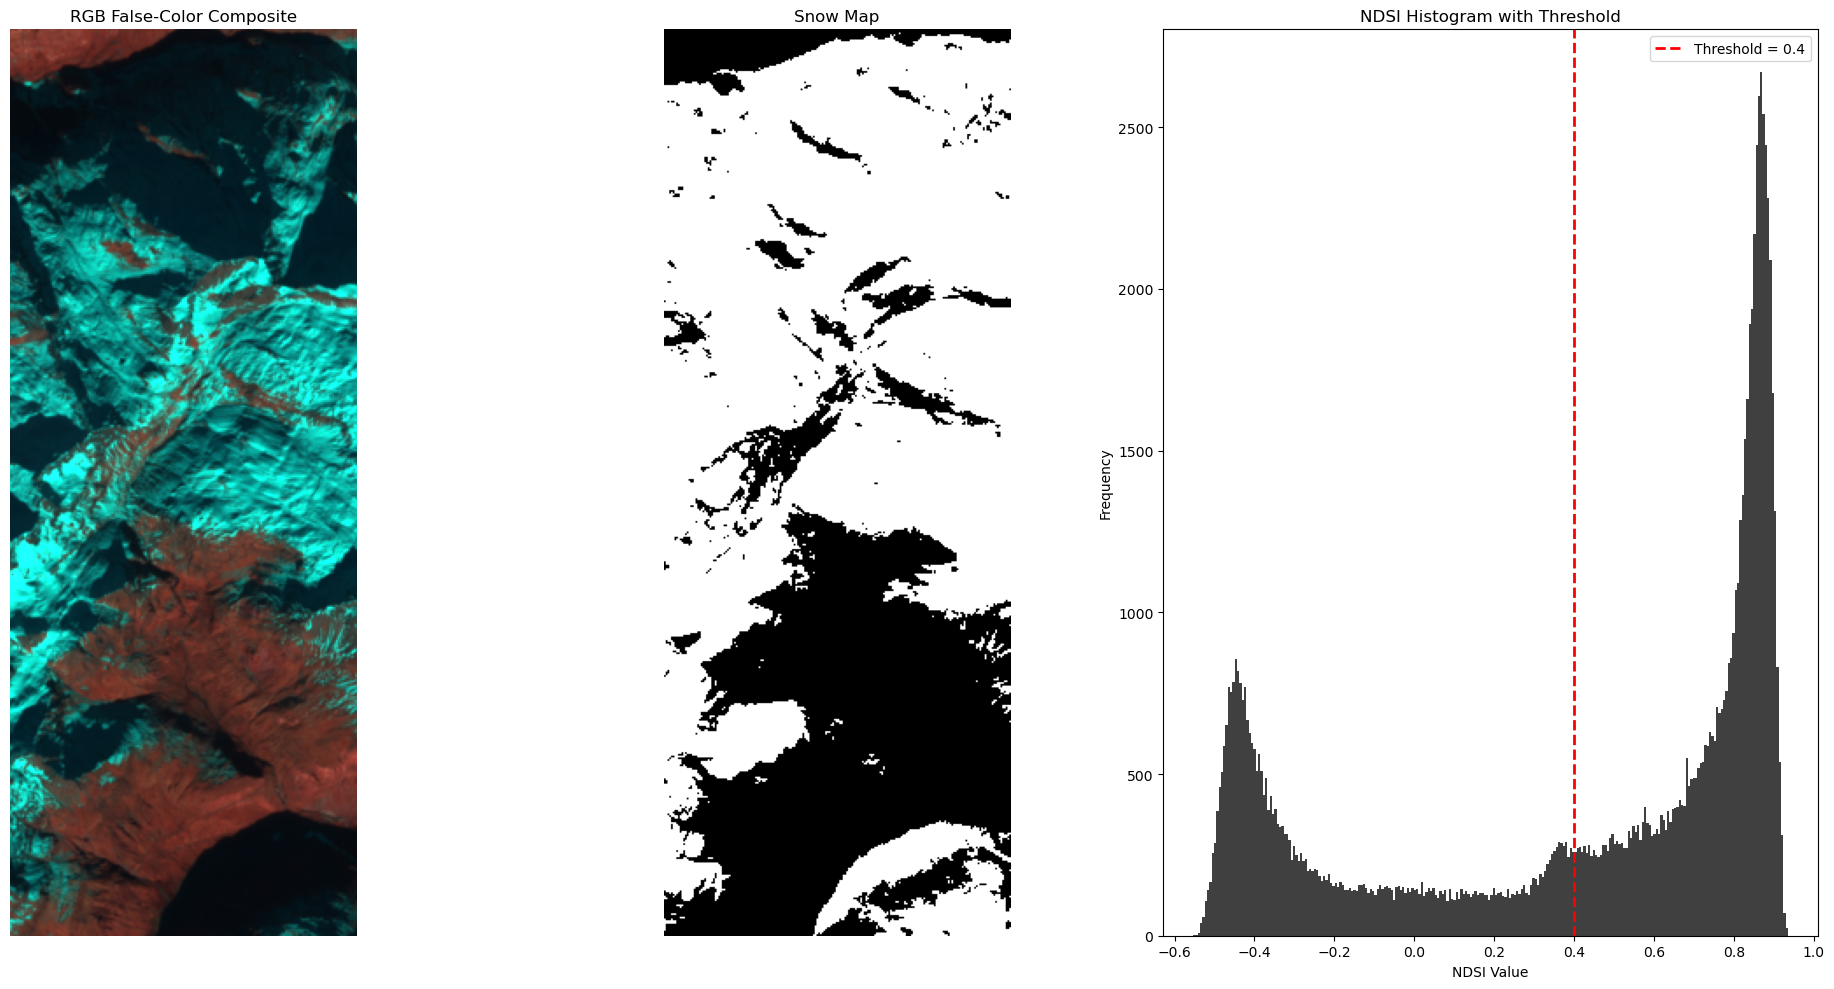

In [162]:
# Define an NDSI threshold for snow mapping (students can modify this value)
ndsi_threshold = 0.4  # Example threshold, students can experiment with different values

# Define the band names for RGB (false color), Green, and SWIR bands
NIR_band_name = 'B08'
green_band_name = 'B03'
swir_band_name = 'B11'

# Get the current working directory
current_dir = os.getcwd()

# Use glob to find the paths for the necessary bands
NIR_band_path = glob.glob(os.path.join('./S2*', '*' + red_band_name + '*.tif'))[0]
green_band_path = glob.glob(os.path.join('./S2*', '*' + green_band_name + '*.tif'))[0]
swir_band_path = glob.glob(os.path.join('./S2*', '*' + swir_band_name + '*.tif'))[0]

# Open and read the RGB and SWIR bands
with rasterio.open(NIR_band_path) as NIR_dataset, \
     rasterio.open(green_band_path) as green_dataset, \
     rasterio.open(swir_band_path) as swir_dataset:
    
    # Read the bands as 2D arrays
    NIR_band = NIR_dataset.read(1)
    green_band = green_dataset.read(1)
    swir_band = swir_dataset.read(1)

    # Calculate the NDSI using the formula: (Green - SWIR) / (Green + SWIR)
    ndsi = (green_band.astype(float) - swir_band.astype(float)) / (green_band + swir_band)
    ndsi = np.where(np.isfinite(ndsi), ndsi, np.nan)  # Handle invalid values

    # Create a binary snow map based on the NDSI threshold
    snow_map = np.where(ndsi > ndsi_threshold, 1, 0)

    # Create an RGB false-color composite (SWIR, Red, Green)
    rgb_false_color = np.dstack((swir_band, NIR_band, green_band))

    # Plot the RGB false-color image, snow map, and NDSI histogram with the threshold
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    
    # Plot the RGB false-color composite
    ax[0].imshow(rgb_false_color)  # Normalizing by 10000 for better visualization
    ax[0].set_title('RGB False-Color Composite')
    ax[0].axis('off')
    
    # Plot the binary snow map
    ax[1].imshow(snow_map, cmap='gray')
    ax[1].set_title('Snow Map')
    ax[1].axis('off')
    
    # Plot the NDSI histogram with the threshold
    ax[2].hist(ndsi.ravel(), bins=256, color='black', alpha=0.75)
    ax[2].set_title('NDSI Histogram with Threshold')
    ax[2].set_xlabel('NDSI Value')
    ax[2].set_ylabel('Frequency')
    ax[2].axvline(ndsi_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {ndsi_threshold}')
    ax[2].legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

***

## Exercise: Snow Cover Fraction (SCF) Mapping with Salomonson

In this exercise, you will calculate the Snow Cover Fraction (SCF) for a given Sentinel-2 scene using the Salomonson approach [1]. SCF is a valuable index in remote sensing, providing an estimate of the fraction of a pixel's area that is covered by snow. This approach allows for more nuanced snow mapping compared to binary classification methods.

### Objective

- Calculate the SCF using the Normalized Difference Snow Index (NDSI) and the Salomonson formula.
- Visualize the SCF map alongside the RGB false-color composite of the scene.
- Explore the relationship between NDSI and SCF and understand how varying snow cover is represented across the landscape.

### Methodology

The SCF is calculated using the following linear relationship derived from the NDSI [1]:

$$
\text{SCF} = 1.45 \times \text{NDSI} - 0.01
$$

Where:

- **SCF**: Snow Cover Fraction, representing the proportion of each pixel that is covered by snow, ranging from 0 (no snow) to 1 (completely snow-covered).

### Expected Outcome

By completing this exercise, you should be able to generate a detailed SCF map, which will provide insight into the snow distribution within the scene. The SCF map allows you to observe areas with varying snow cover intensity, from fully snow-covered regions to those with partial or no snow cover. The side-by-side visualization with the RGB false-color composite will help you interpret and validate your results.

### Instructions

1. **Run the provided code** to calculate the SCF and generate the visualizations.
2. **Experiment with the threshold values** and observe how changes affect the snow map and the SCF calculation.
3. **Analyze the results** to gain a deeper understanding of snow cover distribution in remote sensing data.

### Reflection

This exercise enhances your skills in snow mapping using remote sensing techniques, specifically focusing on the calculation and interpretation of the Snow Cover Fraction. Understanding SCF is crucial for various applications, including hydrology, climatology, and environmental monitoring.

[1] Salomonson, Vincent V., and I. Appel. "Estimating fractional snow cover from MODIS using the normalized difference snow index." Remote sensing of environment 89.3 (2004): 351-360.​


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


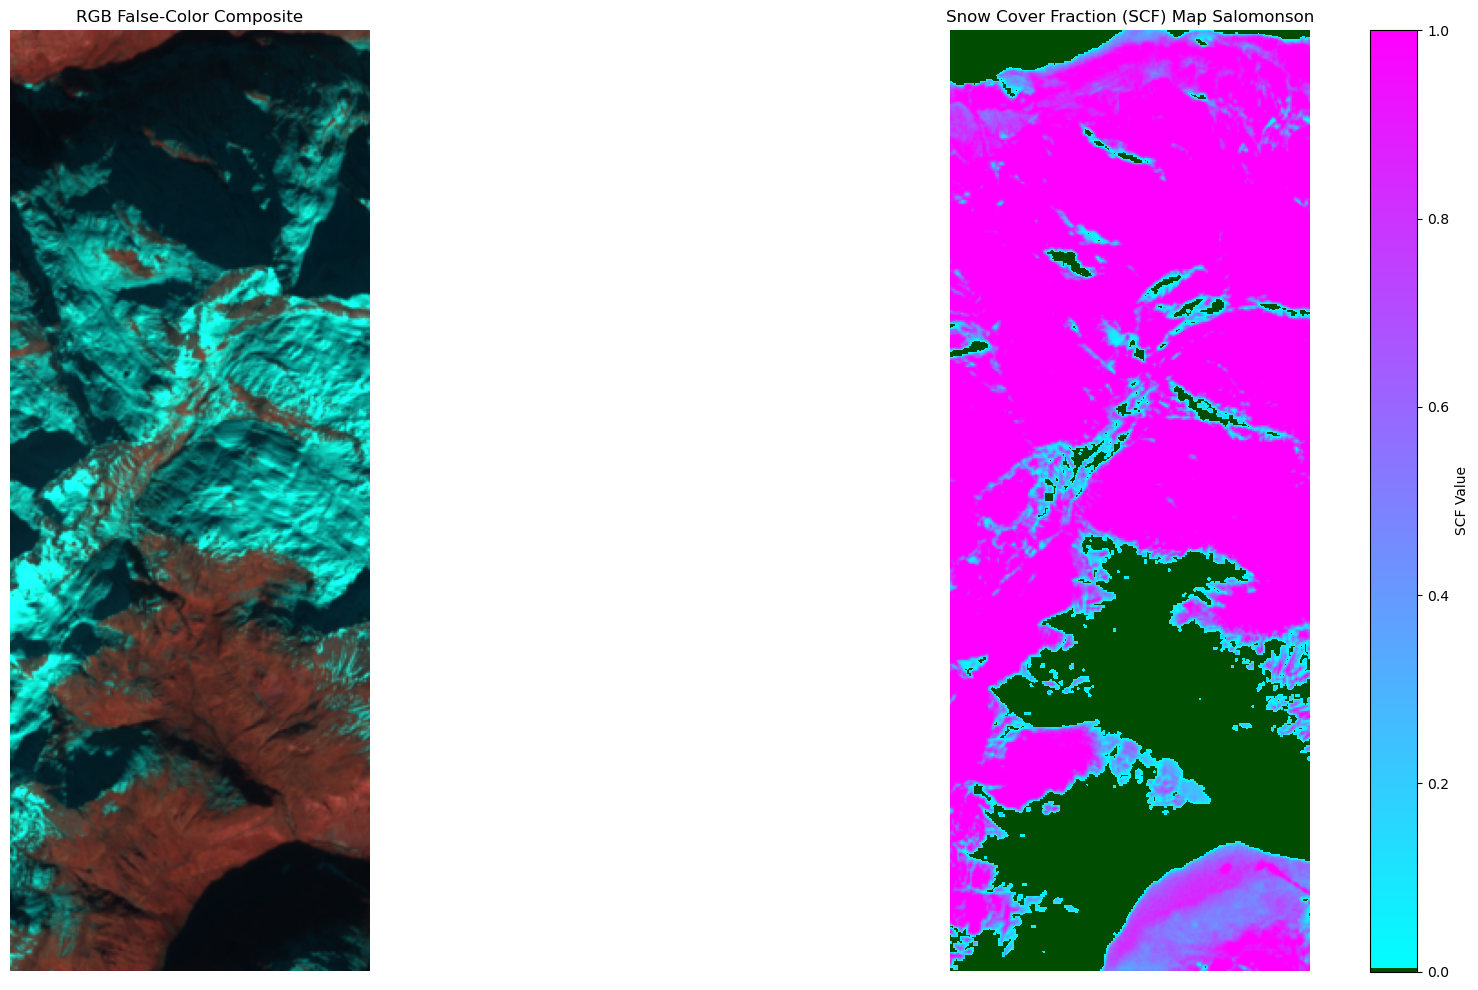

In [167]:
# a: multiplicative factor
a = 1.45

# b: additive factor
b = -0.01

# Calculate the Snow Cover Fraction (SCF) using the Salomonson approach
scf_salomonson = b + a * ndsi
scf_salomonson = np.clip(scf_salomonson, 0, 1)  # Ensure SCF values are within the range [0, 1]

# Plot the RGB false-color image and the SCF map
from matplotlib.colors import ListedColormap
# Create a custom colormap: green for SCF=0, and cool colormap for SCF > 0
cool_colormap = plt.cm.cool(np.linspace(0, 1, 256))  # Cool colormap
cool_colormap[:1, :] = np.array([0, 0.3, 0, 1])  # Set the first color (SCF=0) to green
custom_cmap = ListedColormap(cool_colormap)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot the RGB false-color composite
ax[0].imshow(rgb_false_color)  # Normalizing by 10000 for better visualization
ax[0].set_title('RGB False-Color Composite')
ax[0].axis('off')

# Plot the Snow Cover Fraction (SCF) map
scf_plot = ax[1].imshow(scf_salomonson, cmap=custom_cmap, vmin=0, vmax=1)
ax[1].set_title('Snow Cover Fraction (SCF) Map Salomonson')
ax[1].axis('off')

# Add a colorbar to the SCF map
cbar = plt.colorbar(scf_plot, ax=ax[1], orientation='vertical')
cbar.set_label('SCF Value')

# Display the plots
plt.tight_layout()
plt.show()

***

## Exercise: Snow Cover Fraction (SCF) Mapping with Sigmoid

In this exercise, you will calculate the Snow Cover Fraction (SCF) for a given Sentinel-2 scene using the Sigmoid approach [2]. SCF is a valuable index in remote sensing, providing an estimate of the fraction of a pixel's area that is covered by snow. This approach allows for more nuanced snow mapping compared to binary classification methods.

### Objective

- Calculate the SCF using the Normalized Difference Snow Index (NDSI) and the Sigmoid formula.
- Visualize the SCF map alongside the RGB false-color composite of the scene.
- Explore the relationship between NDSI and SCF and understand how varying snow cover is represented across the landscape.

### Methodology

The SCF is calculated using the following linear relationship derived from the NDSI:

$$
\text{SCF} = \frac{1}{2}tanh(2.65NDSI-1.42)+0.5
$$


### Expected Outcome

By completing this exercise, you should be able to generate a detailed SCF map, which will provide insight into the snow distribution within the scene. The SCF map allows you to observe areas with varying snow cover intensity, from fully snow-covered regions to those with partial or no snow cover. The side-by-side visualization with the RGB false-color composite will help you interpret and validate your results.

### Instructions

1. **Run the provided code** to calculate the SCF and generate the visualizations.
2. **Experiment with the threshold values** and observe how changes affect the snow map and the SCF calculation.
3. **Analyze the results** to gain a deeper understanding of snow cover distribution in remote sensing data.

### Reflection

This exercise enhances your skills in snow mapping using remote sensing techniques, specifically focusing on the calculation and interpretation of the Snow Cover Fraction. Understanding SCF is crucial for various applications, including hydrology, climatology, and environmental monitoring.

[2] Gascoin, S.; Barrou Dumont, Z.; Deschamps-Berger, C.; Marti, F.; Salgues, G.; López-Moreno, J.I.; Revuelto, J.; Michon, T.; Schattan, P.; Hagolle, O. Estimating Fractional Snow Cover in Open Terrain from Sentinel-2 Using the Normalized Difference Snow Index. Remote Sens. 2020, 12, 2904. https://doi.org/10.3390/rs12182904 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


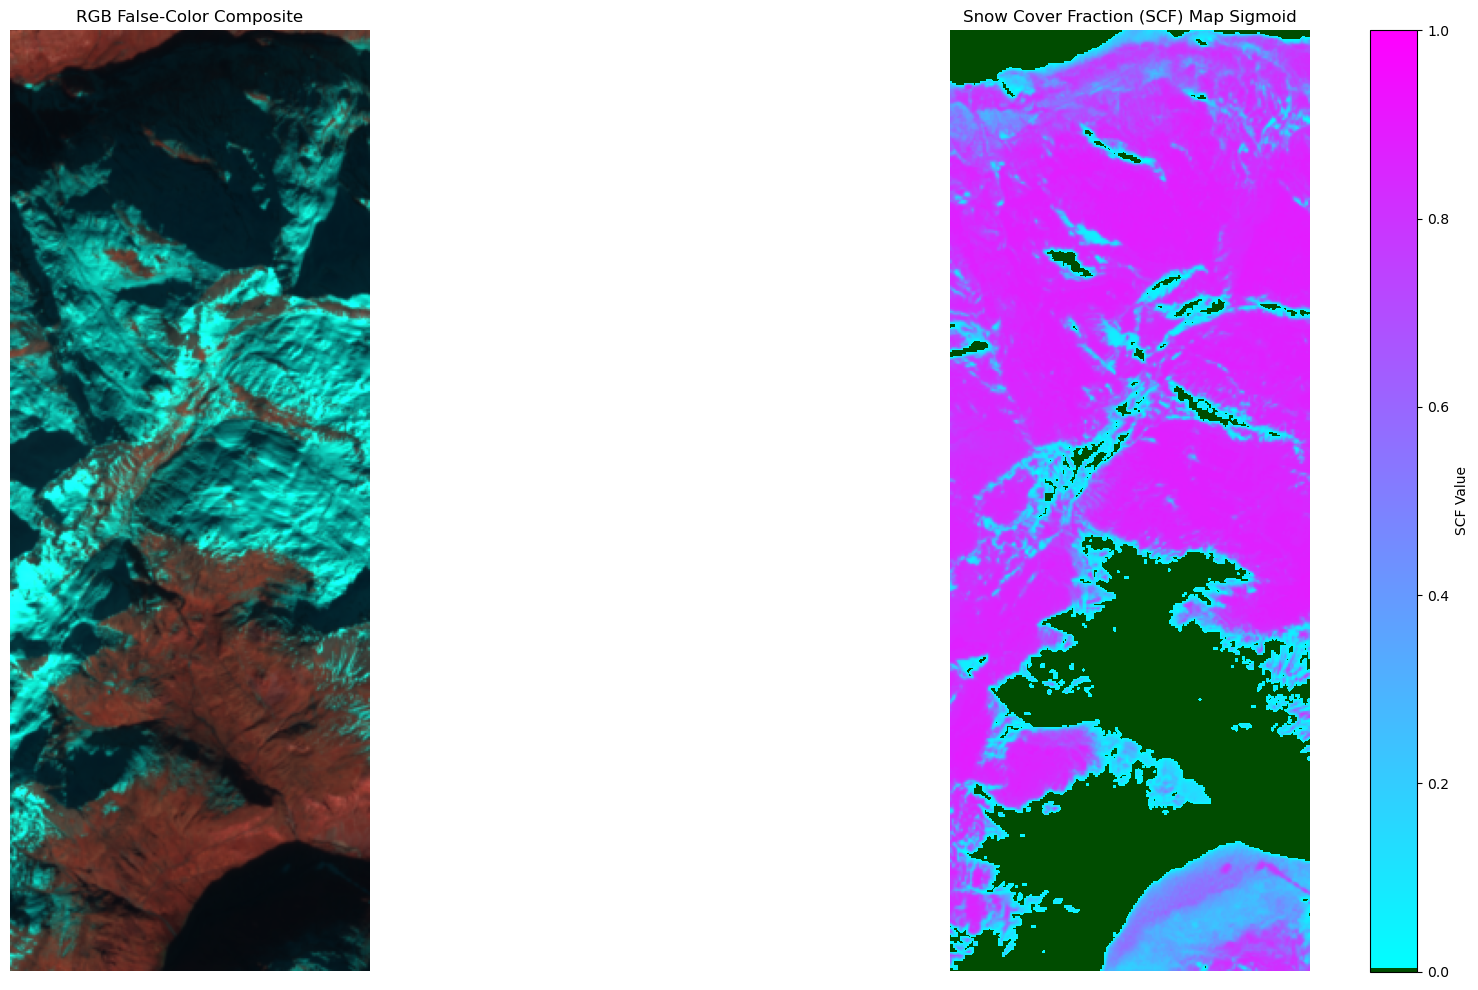

In [168]:
# c: multiplicative factor
c = 2.65
# d: additive factor
d = 1.42

# Calculate the Snow Cover Fraction (SCF) using the Salomonson approach
scf_sigmoid = 0.5*np.tanh(c*ndsi-d)+0.5
scf_sigmoid = np.clip(scf_sigmoid, 0, 1)  # Ensure SCF values are within the range [0, 1]
scf_sigmoid[ndsi<=0] = 0

# Plot the RGB false-color image and the SCF map
from matplotlib.colors import ListedColormap
# Create a custom colormap: green for SCF=0, and cool colormap for SCF > 0
cool_colormap = plt.cm.cool(np.linspace(0, 1, 256))  # Cool colormap
cool_colormap[:1, :] = np.array([0, 0.3, 0, 1])  # Set the first color (SCF=0) to green
custom_cmap = ListedColormap(cool_colormap)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot the RGB false-color composite
ax[0].imshow(rgb_false_color)  # Normalizing by 10000 for better visualization
ax[0].set_title('RGB False-Color Composite')
ax[0].axis('off')

# Plot the Snow Cover Fraction (SCF) map
scf_plot = ax[1].imshow(scf_sigmoid, cmap=custom_cmap, vmin=0, vmax=1)
ax[1].set_title('Snow Cover Fraction (SCF) Map Sigmoid')
ax[1].axis('off')

# Add a colorbar to the SCF map
cbar = plt.colorbar(scf_plot, ax=ax[1], orientation='vertical')
cbar.set_label('SCF Value')

# Display the plots
plt.tight_layout()
plt.show()

***

## Multispectral Unmixing - Endmember selection


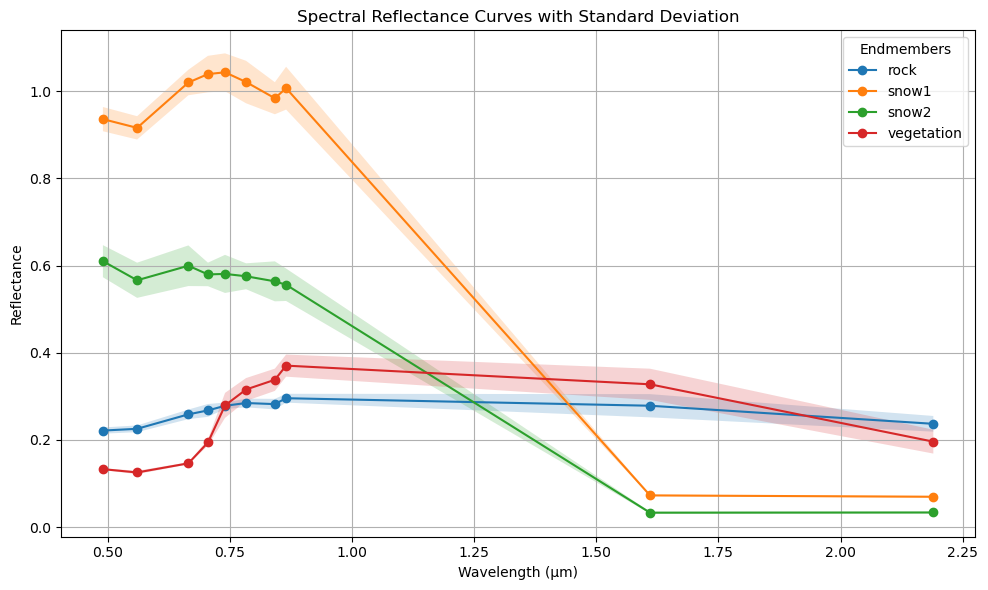

In [159]:
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.sample import sample_gen
import pandas as pd
import numpy as np

# Function to extract raster values for each point in the shapefile
def extract_raster_values(shapefile_path, raster_path):
    # Read the shapefile
    gdf = gpd.read_file(shapefile_path)
    
    # Open the raster file
    with rasterio.open(raster_path) as src:
        # Extract raster values for each point
        coords = [(point.x, point.y) for point in gdf.geometry]
        values = list(sample_gen(src, coords))
        
        # Flatten the values if there are multiple bands
        if src.count > 1:
            values = [[value[i] for i in range(src.count)] for value in values]
        else:
            values = [value[0] for value in values]
    
    # Create a dataframe with the extracted values and class column
    df = pd.DataFrame(values, columns=[f'Band_{i}' for i in range(1, src.count + 1)])
    
    # Add the class column from the shapefile
    df['class'] = gdf['class'].values
    return df

# Function to compute the mean and standard deviation by class
def stats_by_class(df, class_column='class'):
    # Compute the mean and std for each class
    mean_df = df.groupby(class_column).mean().reset_index()
    std_df = df.groupby(class_column).std().reset_index()
    
    return mean_df, std_df

# Example usage
shapefile_path = '/mnt/CEPH_PROJECTS/ALPSNOW/Riccardo/ESA_Training/shapefiles/endmembers_msu.shp'
raster_path = '/mnt/CEPH_PROJECTS/ALPSNOW/Riccardo/ESA_Training/S2B_MSIL1C_20201125T103349_N0209_R108_T32TLR_20201125T114106_10m/S2B_MSIL1C_20201125T103349_N0209_R108_T32TLR_20201125T114106_10m_scf.vrt'

bands_wavelengths = [0.490, 0.560, 0.665, 0.705, 0.740, 0.783, 0.842, 0.865, 1.610, 2.190]

# Extract the raster values and compute the mean and std by class
df = extract_raster_values(shapefile_path, raster_path)
mean_df, std_df = stats_by_class(df, class_column='class')

# Plotting reflectance curves with shaded buffer (std as the shaded area)
plt.figure(figsize=(10, 6))

# Plot each endmember reflectance curve with shaded error
for index, row in mean_df.iterrows():
    class_name = row['class']
    reflectance_means = row[1:].astype(float).values  # Convert to float

    # Get the corresponding std values for the same class
    std_row = std_df.loc[std_df['class'] == class_name]
    reflectance_stds = std_row.iloc[0, 1:].astype(float).values  # Convert to float

    # Ensure no NaN or None values
    reflectance_means = np.nan_to_num(reflectance_means)
    reflectance_stds = np.nan_to_num(reflectance_stds)

    # Plot the mean reflectance curve
    plt.plot(bands_wavelengths, reflectance_means, label=class_name, marker='o')

    # Fill the area between (mean - std) and (mean + std) with a transparent color
    plt.fill_between(bands_wavelengths, 
                     reflectance_means - reflectance_stds, 
                     reflectance_means + reflectance_stds, 
                     alpha=0.2)  # Set transparency for the filled area

# Set proportional x-axis (wavelengths)
plt.xscale('linear')

# Labeling
plt.title('Spectral Reflectance Curves with Standard Deviation')
plt.xlabel('Wavelength (µm)')
plt.ylabel('Reflectance')
plt.legend(title='Endmembers')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


***
** Multispectral Unmixing - Unmixing process

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   30.4s remaining:  1.5min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   30.8s remaining:   51.3s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:   31.8s remaining:   31.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   32.8s remaining:   19.7s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:   34.1s remaining:   11.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   35.5s finished
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


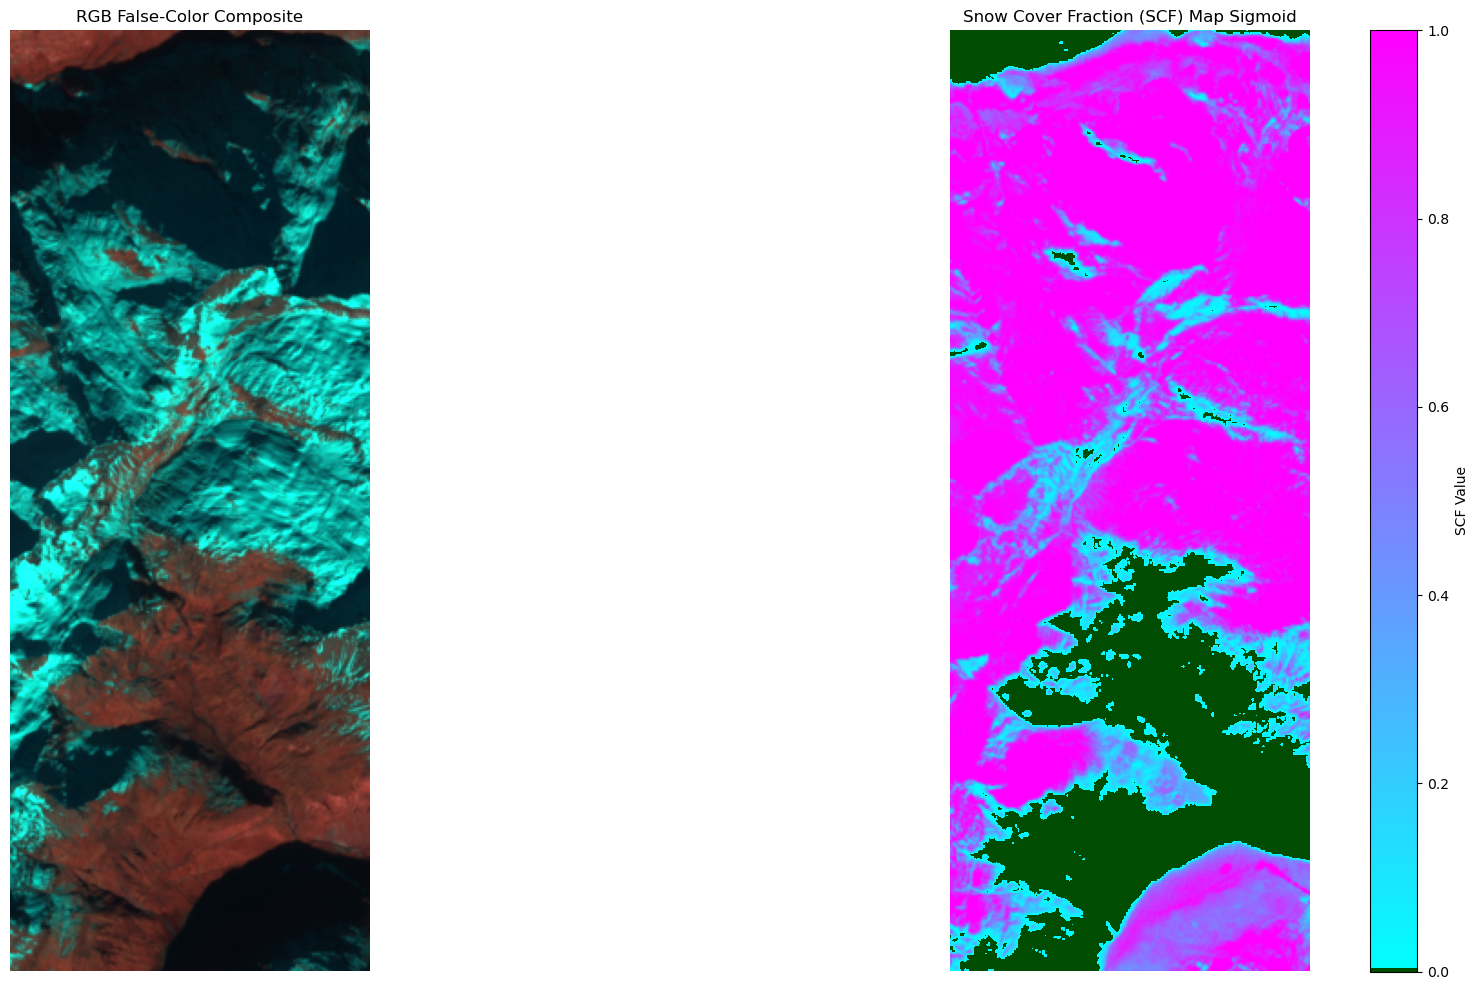

In [160]:
from rasterio.plot import reshape_as_image, reshape_as_raster
from scipy.optimize import lsq_linear
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt

def sp_unmixing(endmembers_matrix, array_to_unmix):
    bounds = (0, 1)
    scf_array = np.zeros((len(array_to_unmix)))

    for curr_pix in range(np.shape(array_to_unmix)[0]):
        r = array_to_unmix[curr_pix, :].astype('double')

        abundances = lsq_linear(endmembers_matrix, r, bounds, lsq_solver=None, lsmr_tol=None, max_iter=None, verbose=0)['x']
        snow_abundance = abundances[1] + abundances[2]
        
        sum_of_unshaded_abundances = np.sum(abundances)
        scf = (snow_abundance / sum_of_unshaded_abundances) if sum_of_unshaded_abundances != 0 else 0
        scf_array[curr_pix] = scf

    return scf_array

Nprocesses = 8

with rasterio.open(raster_path) as src:
    raster_data = src.read()

img_reshaped = np.array(raster_data.reshape(src.count, -1)).T  # (num_pixels, num_bands)
endmembers_matrix = endmembers_df.drop(columns='class').values.T  # Prepare the endmembers matrix

# Split the image data into chunks for parallel processing
samplesBlocks = np.array_split(img_reshaped, Nprocesses, axis=0)

# Perform spectral unmixing in parallel
scf_blocks = Parallel(n_jobs=Nprocesses, verbose=10)(
    delayed(sp_unmixing)(endmembers_matrix, samplesBlocks[i]) for i in range(Nprocesses)
)

# Combine the results from the parallel blocks back into a single array
scf_array = np.concatenate(scf_blocks, axis=0)

# Reshape the scf_array to the original raster shape
scf_unmixing = scf_array.reshape(np.shape(raster_data[0]))

# Plotting the results
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot the RGB false-color composite (assuming you have this variable from somewhere)
ax[0].imshow(rgb_false_color)  # Normalizing by 10000 for better visualization
ax[0].set_title('RGB False-Color Composite')
ax[0].axis('off')

# Plot the Snow Cover Fraction (SCF) map
scf_plot = ax[1].imshow(scf_unmixing, cmap=custom_cmap, vmin=0, vmax=1)
ax[1].set_title('Snow Cover Fraction (SCF) Map Sigmoid')
ax[1].axis('off')

# Add a colorbar to the SCF map
cbar = plt.colorbar(scf_plot, ax=ax[1], orientation='vertical')
cbar.set_label('SCF Value')

# Display the plots
plt.tight_layout()
plt.show()


***

## Non-linear Unmixing - Endmember selection
